In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib

In [2]:
feature_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg"
)
print("MobileNetV2 loaded successfully")

C:\Users\rawan\AppData\Local\Temp\ipykernel_4676\4283438812.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_model = MobileNetV2(


MobileNetV2 loaded successfully


In [3]:
def extract_feature(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = feature_model.predict(img_array, verbose=0)
    return feature.flatten()

In [4]:
def process_folder(base_path):
    X, y_stage1, y_class = [], [], []

    for category in ["fruit", "vegetable"]:
        category_path = os.path.join(base_path, category)
        for class_name in os.listdir(category_path):
            class_path = os.path.join(category_path, class_name)
            if not os.path.isdir(class_path):
                continue
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    X.append(extract_feature(img_path))
                    y_stage1.append(0 if category == "fruit" else 1)
                    y_class.append(class_name)
                except:
                    print("Failed to load:", img_path)

    return np.array(X), np.array(y_stage1), np.array(y_class)

In [5]:
train_dir = r"C:\Users\rawan\Desktop\fruit_veg_classifier\train"
X_train, y_train, y_train_class = process_folder(train_dir)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("y_train_class.npy", y_train_class)

print("Training data prepared:", X_train.shape)

c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training data prepared: (3115, 1280)


In [6]:
test_dir = r"C:\Users\rawan\Desktop\fruit_veg_classifier\test"
X_test, y_test, y_test_class = process_folder(test_dir)

np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("y_test_class.npy", y_test_class)

print("Testing data prepared:", X_test.shape)


Testing data prepared: (359, 1280)


In [10]:
stage1_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

stage1_model.fit(X_train, y_train)
y_pred_stage1 = stage1_model.predict(X_test)

print(f"Stage 1 Accuracy: {accuracy_score(y_test, y_pred_stage1)*100:.2f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stage1))
print("Classification Report:\n", classification_report(y_test, y_pred_stage1))

joblib.dump(stage1_model, "stage1_xgb_model.pkl")
print("Stage 1 model saved")

c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\xgboost\core.py:158: UserWarning: [11:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stage 1 Accuracy: 95.82%
Confusion Matrix:
 [[ 74  15]
 [  0 270]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        89
           1       0.95      1.00      0.97       270

    accuracy                           0.96       359
   macro avg       0.97      0.92      0.94       359
weighted avg       0.96      0.96      0.96       359

Stage 1 model saved


In [11]:
fruit_idx_train = np.where(y_train == 0)[0]
veg_idx_train   = np.where(y_train == 1)[0]

fruit_idx_test = np.where(y_test == 0)[0]
veg_idx_test   = np.where(y_test == 1)[0]

X_train_fruit = X_train[fruit_idx_train]
y_train_fruit = y_train_class[fruit_idx_train]
X_test_fruit = X_test[fruit_idx_test]
y_test_fruit = y_test_class[fruit_idx_test]

X_train_veg = X_train[veg_idx_train]
y_train_veg = y_train_class[veg_idx_train]
X_test_veg = X_test[veg_idx_test]
y_test_veg = y_test_class[veg_idx_test]

In [14]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# ---------- FRUIT ----------
# Keep only test samples that exist in training classes
fruit_train_classes = np.unique(y_train_fruit)
mask_fruit = np.isin(y_test_fruit, fruit_train_classes)
X_test_fruit = X_test_fruit[mask_fruit]
y_test_fruit = y_test_fruit[mask_fruit]

# Label encoding
fruit_encoder = LabelEncoder()
y_train_fruit_enc = fruit_encoder.fit_transform(y_train_fruit)
y_test_fruit_enc = fruit_encoder.transform(y_test_fruit)

# ---------- VEGETABLE ----------
# Keep only test samples that exist in training classes
veg_train_classes = np.unique(y_train_veg)
mask_veg = np.isin(y_test_veg, veg_train_classes)
X_test_veg = X_test_veg[mask_veg]
y_test_veg = y_test_veg[mask_veg]

# Label encoding
veg_encoder = LabelEncoder()
y_train_veg_enc = veg_encoder.fit_transform(y_train_veg)
y_test_veg_enc = veg_encoder.transform(y_test_veg)

print("Label encoding done. Fruit classes:", fruit_encoder.classes_)
print("Vegetable classes:", veg_encoder.classes_)

Label encoding done. Fruit classes: ['apple' 'banana' 'grapes' 'kiwi' 'mango' 'pineapple' 'pomegranate'
 'watermelon']
Vegetable classes: ['beetroot' 'bell pepper' 'cabbage' 'capsicum' 'carrot' 'cauliflower'
 'chilli pepper' 'corn' 'cucumber' 'eggplant' 'garlic' 'ginger' 'jalepeno'
 'lemon' 'lettuce' 'onion' 'orange' 'paprika' 'pear' 'peas' 'potato'
 'raddish' 'soy beans' 'spinach' 'sweetcorn' 'sweetpotato' 'tomato'
 'turnip']


In [15]:
fruit_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

fruit_model.fit(X_train_fruit, y_train_fruit_enc)
y_pred_fruit_enc = fruit_model.predict(X_test_fruit)
y_pred_fruit = fruit_encoder.inverse_transform(y_pred_fruit_enc)

print(f"Fruit Accuracy: {accuracy_score(y_test_fruit, y_pred_fruit)*100:.2f}%")
print("Fruit Confusion Matrix:\n", confusion_matrix(y_test_fruit, y_pred_fruit))
print("Fruit Classification Report:\n", classification_report(y_test_fruit, y_pred_fruit))

joblib.dump(fruit_model, "fruit_xgb_model.pkl")
print("Fruit-Type model saved")

c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\xgboost\core.py:158: UserWarning: [12:01:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fruit Accuracy: 94.94%
Fruit Confusion Matrix:
 [[ 8  0  0  1  0  0  0  1]
 [ 0  7  0  0  2  0  0  0]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0 10]]
Fruit Classification Report:
               precision    recall  f1-score   support

       apple       1.00      0.80      0.89        10
      banana       1.00      0.78      0.88         9
      grapes       1.00      1.00      1.00        10
        kiwi       0.91      1.00      0.95        10
       mango       0.83      1.00      0.91        10
   pineapple       1.00      1.00      1.00        10
 pomegranate       1.00      1.00      1.00        10
  watermelon       0.91      1.00      0.95        10

    accuracy                           0.95        79
   macro avg       0.96      0.95      0.95        79
weighted avg       0.96      0.95      0.95        79

Fruit-Type model saved


In [16]:
veg_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

veg_model.fit(X_train_veg, y_train_veg_enc)
y_pred_veg_enc = veg_model.predict(X_test_veg)
y_pred_veg = veg_encoder.inverse_transform(y_pred_veg_enc)

print(f"Vegetable Accuracy: {accuracy_score(y_test_veg, y_pred_veg)*100:.2f}%")
print("Vegetable Confusion Matrix:\n", confusion_matrix(y_test_veg, y_pred_veg))
print("Vegetable Classification Report:\n", classification_report(y_test_veg, y_pred_veg))

joblib.dump(veg_model, "veg_xgb_model.pkl")
print("Vegetable-Type model saved")

c:\Users\rawan\.conda\envs\ai_env\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Vegetable Accuracy: 97.78%
Vegetable Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

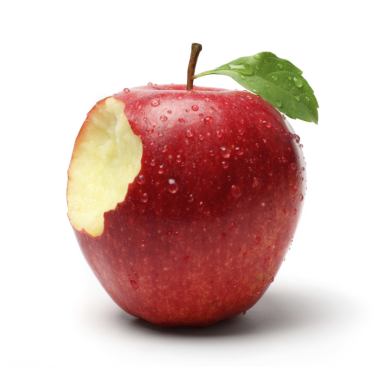

Category: Fruit
Predicted Type: apple


In [19]:
def predict_image(img_path):
    # Display image
    img = load_img(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Extract features
    feature = extract_feature(img_path).reshape(1, -1)

    # Stage 1: Fruit vs Vegetable
    stage1_pred = stage1_model.predict(feature)[0]

    if stage1_pred == 0:
        # Fruit: use label encoder + numeric model
        label_enc = fruit_model.predict(feature)[0]  # numeric
        label_name = fruit_encoder.inverse_transform([label_enc])[0]
        print("Category: Fruit")
    else:
        # Vegetable: use label encoder + numeric model
        label_enc = veg_model.predict(feature)[0]  # numeric
        label_name = veg_encoder.inverse_transform([label_enc])[0]
        print("Category: Vegetable")

    print("Predicted Type:", label_name)

# Example usage:
predict_image(r"C:\Users\rawan\Desktop\fruit_veg_classifier\test\fruit\Apple\Image_1.jpg")
